Importing the necessary packages

In [ ]:
import os
import cv2
import tensorflow as tf
import numpy as np
from tensorflow.keras import layers, optimizers
from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.layers import Input, Add, Dense, Activation, ZeroPadding2D, BatchNormalization, Flatten, Conv2D, AveragePooling2D, MaxPooling2D, Dropout
from tensorflow.keras.models import Model, load_model
from tensorflow.keras import backend as K
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping, ModelCheckpoint, LearningRateScheduler
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd


/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


Mounting the drive

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [ ]:
XRay_Directory = '/content/drive/My Drive//all'

In [ ]:
image_generator = ImageDataGenerator(rescale = 1./255, validation_split= 0.2)

Data augmentation is used to increase the diversity of data.

In [ ]:
train_datagen = ImageDataGenerator(
    rotation_range = 20,
    width_shift_range = 0.2,
    height_shift_range = 0.2,
    shear_range = 0.2,
    zoom_range = 0.2,
    horizontal_flip = True
)

train_generator = image_generator.flow_from_directory(
    batch_size = 4, 
    directory= '/content/drive/My Drive/all/train', 
    shuffle= True, 
    target_size=(256,256), 
    class_mode = 'categorical', 
    subset="training")

Found 216 images belonging to 4 classes.


In [ ]:
val_generator = image_generator.flow_from_directory(
    batch_size = 4,
    directory= '/content/drive/My Drive/all/test', 
    shuffle= True, 
    target_size=(256,256), 
    class_mode = 'categorical', 
    subset="validation")

Found 4 images belonging to 4 classes.


In [ ]:
train_images, train_labels = next(train_generator)

In [ ]:
train_images.shape

(4, 256, 256, 3)

In [ ]:
train_labels.shape

(4, 4)

Mapping the categories

In [ ]:
label_names = {0 : 'Covid-19', 1 : 'Normal' , 2: 'Viral Pneumonia', 3 : 'Bacterial Pneumonia'}

Visualizing the dataset

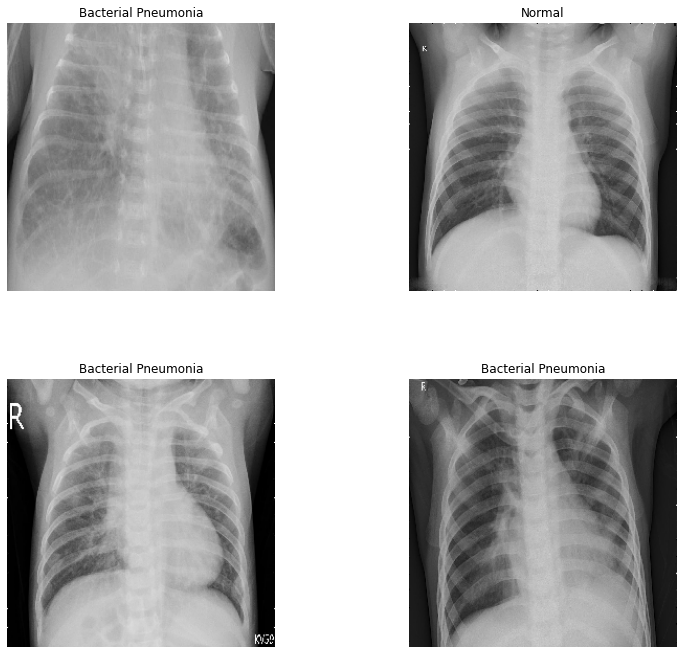

In [ ]:
# Create a grid of 36 images along with their corresponding labels
L = 2
W = 2

fig, axes = plt.subplots(L, W, figsize = (12, 12))
axes = axes.ravel()

for i in np.arange(0, L*W):
    axes[i].imshow(train_images[i])
    axes[i].set_title(label_names[np.argmax(train_labels[i])])
    axes[i].axis('off')

plt.subplots_adjust(wspace = 0.5)    

Using ResNet50 for transfer learning

In [ ]:
basemodel = ResNet50(weights = 'imagenet', include_top = False, input_tensor = Input(shape=(256,256,3)))

94773248/94765736 [==============================] - 1s 0us/step


In [ ]:
basemodel.summary()

Model: "resnet50"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 262, 262, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 128, 128, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 128, 128, 64) 256         conv1_conv[0][0]                 
___________________________________________________________________________________________

In [ ]:
#freezing the model layer for training purpose

for layer in basemodel.layers[:-10]:
  layer.trainable = False

In [ ]:
mod = basemodel.output
mod = AveragePooling2D(pool_size = (4,4))(mod)
mod = Flatten(name= 'flatten')(mod)
mod = Dense(1024, activation = "relu")(mod)
mod = Dropout(0.3)(mod)
mod = Dense(512, activation =  "relu")(mod)
mod = Dropout(0.2)(mod)
mod = Dense(256, activation =  "relu")(mod)
mod = Dropout(0.1)(mod)
mod = Dense(4, activation = 'softmax')(mod)

model = Model(inputs = basemodel.input, outputs = mod)

In [ ]:
model.compile(loss = 'categorical_crossentropy', optimizer=optimizers.RMSprop(lr = 1e-4, decay = 1e-4), metrics= ["accuracy"])

In [ ]:
# using early stopping to exit training if validation loss is not decreasing even after certain epochs (patience)
earlystopping = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=20)

# save the best model with lower validation loss
checkpointer = ModelCheckpoint(filepath="/content/drive/My Drive/all/model.h5", verbose=1, save_best_only=True)

In [ ]:
history = model.fit_generator(train_generator, steps_per_epoch= train_generator.n // 4, epochs = 25, validation_data= val_generator, validation_steps= val_generator.n // 4, callbacks=[checkpointer, earlystopping])

Instructions for updating:
Please use Model.fit, which supports generators.
Epoch 1/25
54/54 [==============================] - ETA: 0s - loss: 1.5224 - accuracy: 0.3426
Epoch 00001: val_loss improved from inf to 1.50395, saving model to /content/drive/My Drive/all/model.h5
54/54 [==============================] - 68s 1s/step - loss: 1.5224 - accuracy: 0.3426 - val_loss: 1.5040 - val_accuracy: 0.2500
Epoch 2/25
54/54 [==============================] - ETA: 0s - loss: 1.2723 - accuracy: 0.4769
Epoch 00002: val_loss improved from 1.50395 to 1.43306, saving model to /content/drive/My Drive/all/model.h5
54/54 [==============================] - 63s 1s/step - loss: 1.2723 - accuracy: 0.4769 - val_loss: 1.4331 - val_accuracy: 0.2500
Epoch 3/25
54/54 [==============================] - ETA: 0s - loss: 1.2138 - accuracy: 0.4213
Epoch 00003: val_loss did not improve from 1.43306
54/54 [==============================] - 61s 1s/step - loss: 1.2138 - accuracy: 0.4213 - val_loss: 1.5639 - val_accurac

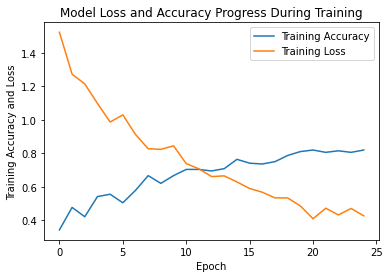

In [ ]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['loss'])

plt.title('Model Loss and Accuracy Progress During Training')
plt.xlabel('Epoch')
plt.ylabel('Training Accuracy and Loss')
plt.legend(['Training Accuracy', 'Training Loss'])

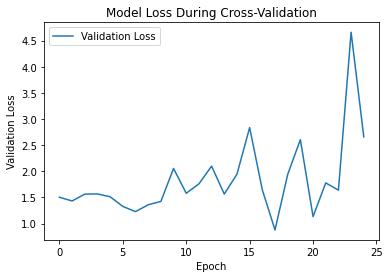

In [ ]:
plt.plot(history.history['val_loss'])
plt.title('Model Loss During Cross-Validation')
plt.xlabel('Epoch')
plt.ylabel('Validation Loss')
plt.legend(['Validation Loss'])

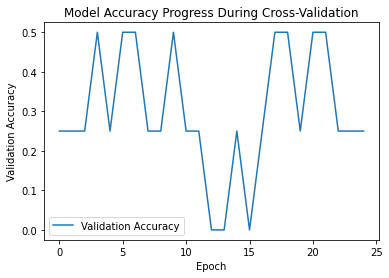

In [ ]:
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy Progress During Cross-Validation')
plt.xlabel('Epoch')
plt.ylabel('Validation Accuracy')
plt.legend(['Validation Accuracy'])

In [ ]:
test_directory = '/content/drive/My Drive/all/train'

In [ ]:
test_gen = ImageDataGenerator(rescale = 1./255)

test_generator = test_gen.flow_from_directory(batch_size = 4, directory= test_directory, shuffle= True, target_size=(256,256), class_mode= 'categorical')

evaluate = model.evaluate_generator(test_generator, steps = test_generator.n // 4, verbose =1)

print('Accuracy Test : {}'.format(evaluate[1]))

Found 270 images belonging to 4 classes.
Instructions for updating:
Please use Model.evaluate, which supports generators.
67/67 [==============================] - 57s 844ms/step - loss: 0.3688 - accuracy: 0.8694
Accuracy Test : 0.8694030046463013


Text(0.5, 1.0, 'Confusion_matrix')

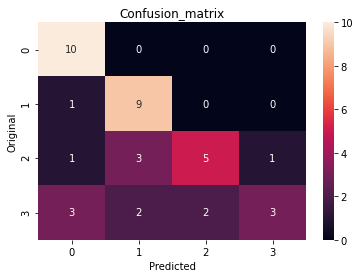

In [ ]:
cm = confusion_matrix(np.asarray(original), np.asarray(prediction))
ax = plt.subplot()
sns.heatmap(cm, annot = True, ax = ax)

ax.set_xlabel('Predicted')
ax.set_ylabel('Original')
ax.set_title('Confusion_matrix')